In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pysentani import *
import sentani as sti
survey = find_survey("../data-anonymous")

../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx


In [34]:
survey['access_type'] = survey['village_name'].apply(lambda x: sti.access_map.get(x))

In [35]:
frequency = {'genset_expenditure':'daily'}

multiplier = {'daily':30}

# creates monthly calculation for genset_expenditure
for column in frequency.keys():
    # adjust expenditure frequency
    expenditure = survey[column] * multiplier[frequency[column]]
    new_column = column + '_monthly'
    survey[new_column] = expenditure
    
# monthly expenditure divided by 960 rp per kWh(.08 USD per kWh * 12000 rp to USD exchange)
# 12000 rp to 1 usd was the exchange rate at time of survey
def genset_kwh_conversion(cv):
    converted = (cv['genset_expenditure_monthly']/(960))
    return converted

survey['genset_kWh'] = survey.apply(genset_kwh_conversion, axis=1)

# kWh multiplied by U.S. EIA estimation of distillate oil(No. 2) CO2 emissions(757.5g/kWh).
# http://www.eia.gov/tools/faqs/faq.cfm?id=74&t=11
def CO2_emission(cv):
    converted = cv['genset_kWh']*757.5 
    return converted

survey['diesel_CO2'] = survey.apply(CO2_emission, axis=1)

# Potential Photovoltaic CO2 production consumption of 105g CO2 per kWh(lifetime) 
# as estimated by BlueSkyModel.org http://blueskymodel.org/kilowatt-hour
def PV_CO2(cv):
    converted = cv['genset_kWh']*105
    return converted

survey['PV_CO2'] = survey.apply(PV_CO2, axis=1)

In [36]:
df = survey.groupby(['access_type'])[['genset_expenditure_monthly','genset_kWh','diesel_CO2','PV_CO2']].mean().dropna()

In [37]:
df.reset_index(inplace=True)
df

,access_type,genset_expenditure_monthly,genset_kWh,diesel_CO2,PV_CO2
0,PLN_grid,5950000.000000,6197.916667,4694921.875000,650781.250000
1,PLN_microgrid,1115789.473684,1162.280702,880427.631579,122039.473684
2,community_microgrid,4500000.000000,4687.500000,3550781.250000,492187.500000
3,no_access,1135787.191011,1183.111657,896207.080407,124226.724017


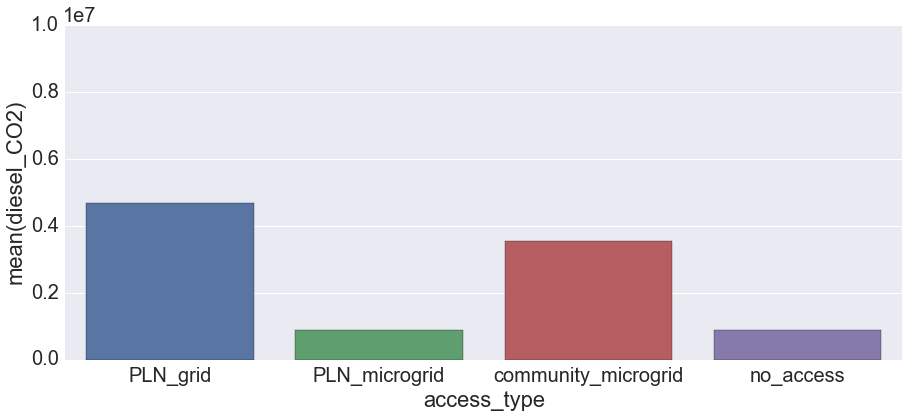

In [39]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x='access_type', y='diesel_CO2',ci=None, data=df)

plt.ylim(0,1e7)
locs, labels = plt.xticks()

### The graph above represents the monthly mean of CO2 measured in g/kWh emitted by diesel generators in Lake Sentani, separated by access type. 

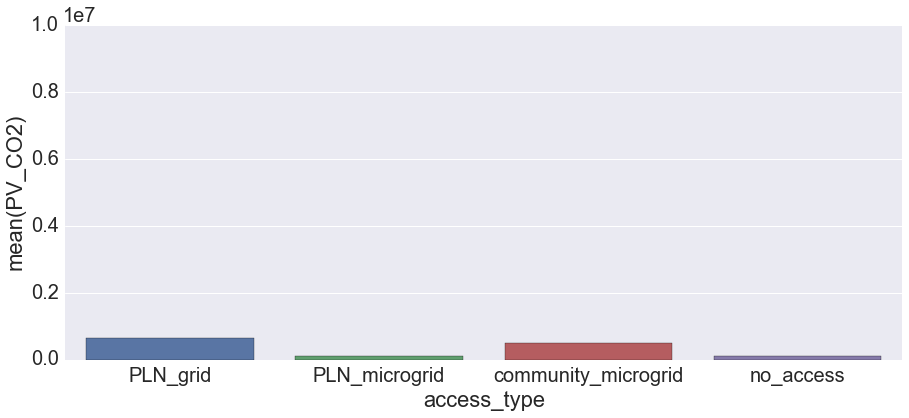

In [40]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x='access_type', y='PV_CO2', ci=None, data=df)

plt.ylim(0,1e7)
locs, labels = plt.xticks()

###This graph represents the amount of CO2 that would be created by PV systems necessary to replace existing diesel generators in Lake Sentani. Measurement is calculated as a monthly mean of g/kWh separated by grid type. 

###Essentially, the calculated reduction would be 86% (105/757.5 = .1386, 1.00 - .1386= .8614)  Of course, this is an intuitive conclusion but the purpose is to demonstrate how much CO2 can be eliminated in Lake Sentani by implementing PV microgrids.

# It should be noted that the majority of expenditure reports come from locations with no access. I believe the reports of genset expenditure from the PLN grid to be inaccurate (17,850,000 rp/mo total for 3 demand points). It is  possible that the community microgrid expenditure reports are also inaccurate (4,500,000 rp/mo total total for one demand point).

In [46]:
survey.groupby(['access_type'])[['genset_expenditure_monthly']].agg(['sum','count'])

genset_expenditure_monthly      
                                           sum count
access_type                                         
PLN_grid                              17850000     3
PLN_microgrid                         63600000    57
community_microgrid                    4500000     1
no_access                            202170120   178

In [47]:
# Total amount by grid type.
df2 = survey.groupby(['access_type'])[['genset_expenditure_monthly','genset_kWh','diesel_CO2','PV_CO2']].sum().dropna()
df2.reset_index(inplace=True)
df2

,access_type,genset_expenditure_monthly,genset_kWh,diesel_CO2,PV_CO2
0,PLN_grid,17850000,18593.750,1.408477e+07,1952343.750
1,PLN_microgrid,63600000,66250.000,5.018438e+07,6956250.000
2,community_microgrid,4500000,4687.500,3.550781e+06,492187.500
3,no_access,202170120,210593.875,1.595249e+08,22112356.875


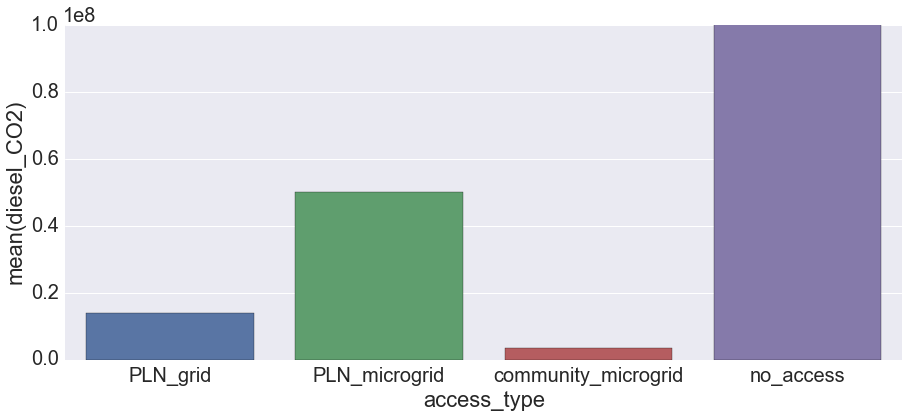

In [52]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x='access_type', y='diesel_CO2', ci=None, data=df2)

plt.ylim(0,1e8)
locs, labels = plt.xticks()

##Now we are looking at the sum of CO2g/kWh which is more representative of what is actually going on in Lake Sentani. Taking the mean of PLN_grid and community_microgrid was throwing off the data in the first two graphs since there are only a few data points for each.

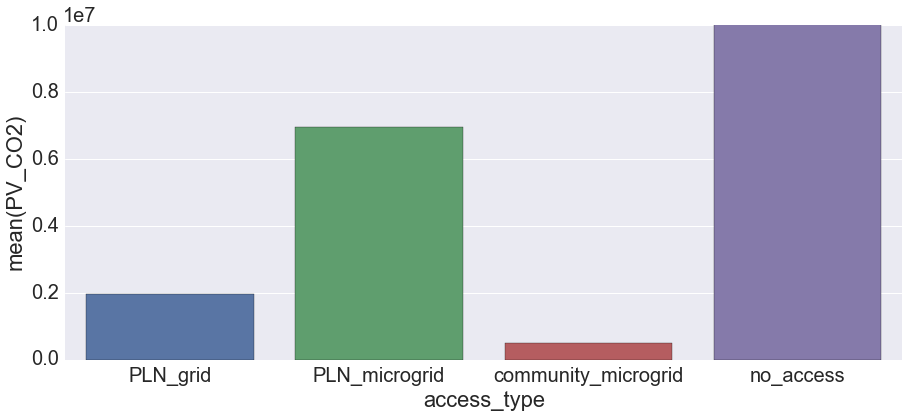

In [48]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x='access_type', y='PV_CO2', ci=None, data=df2)

plt.ylim(0,1e7)
locs, labels = plt.xticks()

##PV CO2 g/kWh emissions with values approximately 1 order of magnitude lower than diesel CO2 emmissions which falls in line with 14% reduction estimate above.